In [3]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -------- ------------------------------- 1.8/8.9 MB 9.1 MB/s eta 0:00:01
   -------------- ------------------------- 3.1/8.9 MB 7.4 MB/s eta 0:00:01
   ----------------- ---------------------- 3.9/8.9 MB 6.0 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.9 MB 5.6 MB/s eta 0:00:01
   ----------------------- ---------------- 5.2/8.9 MB 5.1 MB/s eta 0:00:01
   ------------------------- -------------- 5.8/8.9 MB 4.8 MB/s eta 0:00:01
   ----------------------------- ---------- 6.6/8.9 MB 4.4 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.9 MB 4.4 MB/s eta 0:00:01
   ------------------------------------- -- 8.4/8.9 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 4.2 MB/s  0:00:02
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
    --------------------------------------- 0.8/41.3 MB 4.8 MB/s eta 0:00:09
   -- ---------------------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/raw/diabetic_data.csv')

print("✅ Data loaded successfully!")
print(f"Shape: {df.shape}")

✅ Data loaded successfully!
Shape: (101766, 50)


New Target Variable Created!

Distribution:
readmitted_binary
0    90409
1    11357
Name: count, dtype: int64

Readmission rate: 11.16%


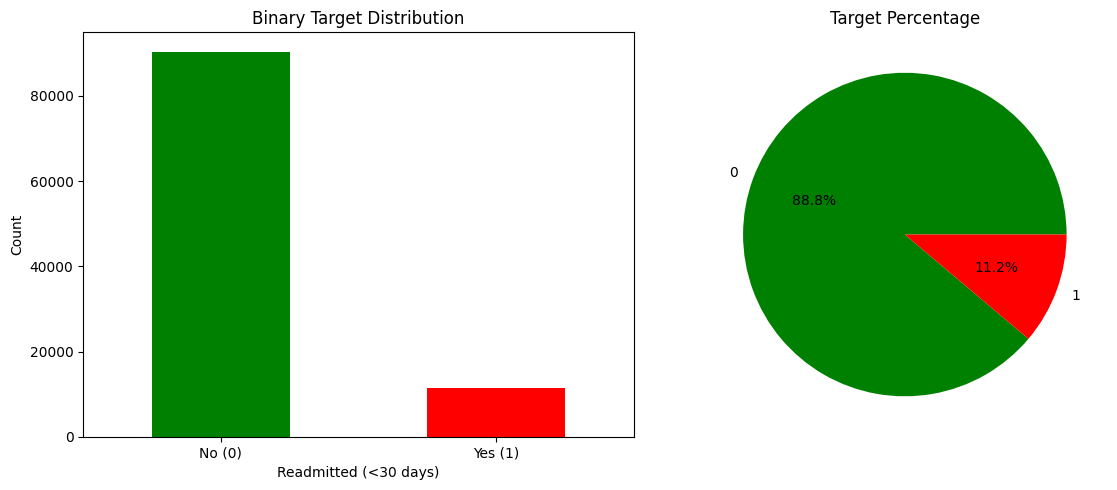

In [5]:
# We want to predict: Will patient be readmitted within 30 days?
# Original values: '<30', '>30', 'NO'
# New target: 1 = readmitted <30 days, 0 = not readmitted <30 days

df['readmitted_binary'] = df['readmitted'].apply(
    lambda x: 1 if x == '<30' else 0
)

print("New Target Variable Created!")
print("\nDistribution:")
print(df['readmitted_binary'].value_counts())
print(f"\nReadmission rate: {df['readmitted_binary'].mean():.2%}")

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df['readmitted_binary'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Binary Target Distribution')
ax[0].set_xlabel('Readmitted (<30 days)')
ax[0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
ax[0].set_ylabel('Count')

df['readmitted_binary'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=['green', 'red'])
ax[1].set_title('Target Percentage')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

Missing Values Check:
               Column  Missing Count  Percentage
5              weight          98569   96.858479
22      max_glu_serum          96420   94.746772
23          A1Cresult          84748   83.277322
11  medical_specialty          49949   49.082208
10         payer_code          40256   39.557416
2                race           2273    2.233555
20             diag_3           1423    1.398306
19             diag_2            358    0.351787
18             diag_1             21    0.020636


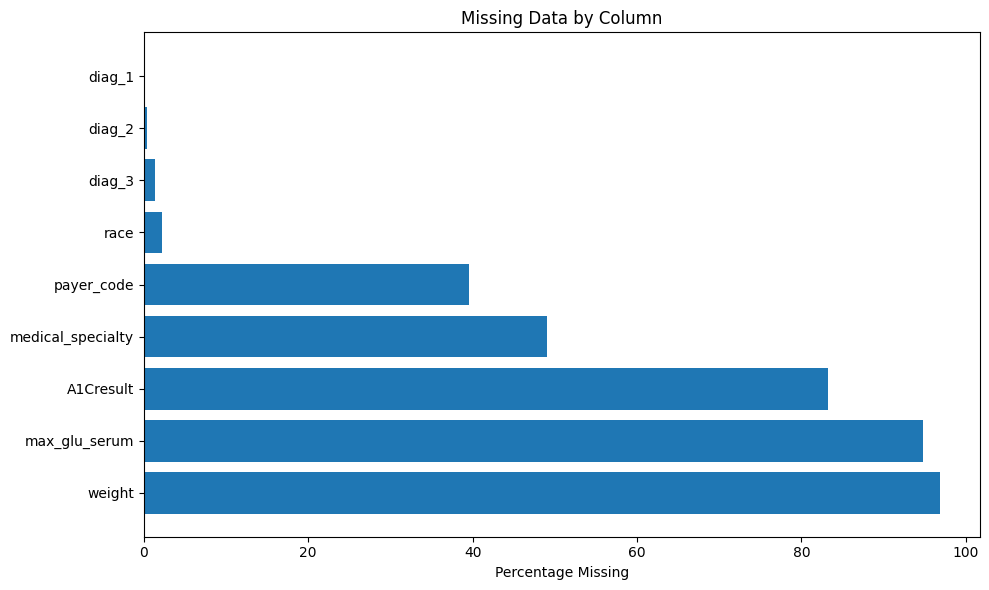

In [6]:
# First, let's see what's missing
print("Missing Values Check:")
print("="*50)

# Many datasets use '?' to represent missing
df_clean = df.replace('?', np.nan)

missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Percentage', ascending=False)

print(missing_df)

# Visualize
if len(missing_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_df['Column'], missing_df['Percentage'])
    plt.xlabel('Percentage Missing')
    plt.title('Missing Data by Column')
    plt.tight_layout()
    plt.show()

In [7]:
# Strategy: Drop columns with >40% missing
threshold = 40
cols_to_drop = missing_df[missing_df['Percentage'] > threshold]['Column'].tolist()

print(f"\nDropping columns with >{threshold}% missing:")
print(cols_to_drop)

df_clean = df_clean.drop(columns=cols_to_drop)
print(f"\n✅ Dropped {len(cols_to_drop)} columns")
print(f"New shape: {df_clean.shape}")


Dropping columns with >40% missing:
['weight', 'max_glu_serum', 'A1Cresult', 'medical_specialty']

✅ Dropped 4 columns
New shape: (101766, 47)


In [8]:
# Age is in ranges: '[70-80)', '[50-60)', etc.
# Let's convert to numeric (use midpoint of range)

age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

df_clean['age_numeric'] = df_clean['age'].map(age_map)

print("Age Conversion:")
print(df_clean[['age', 'age_numeric']].head(10))

# Verify no missing
print(f"\nMissing values in age_numeric: {df_clean['age_numeric'].isnull().sum()}")

Age Conversion:
        age  age_numeric
0    [0-10)            5
1   [10-20)           15
2   [20-30)           25
3   [30-40)           35
4   [40-50)           45
5   [50-60)           55
6   [60-70)           65
7   [70-80)           75
8   [80-90)           85
9  [90-100)           95

Missing values in age_numeric: 0


In [9]:
print("\n" + "="*50)
print("FEATURE ENGINEERING: Previous Utilization")
print("="*50)

# Total previous visits
df_clean['total_visits'] = (
    df_clean['number_outpatient'] + 
    df_clean['number_emergency'] + 
    df_clean['number_inpatient']
)

# Binary flags for any previous visits
df_clean['has_prior_emergency'] = (df_clean['number_emergency'] > 0).astype(int)
df_clean['has_prior_inpatient'] = (df_clean['number_inpatient'] > 0).astype(int)
df_clean['has_prior_outpatient'] = (df_clean['number_outpatient'] > 0).astype(int)

# High utilizer flag (>3 total visits)
df_clean['high_utilizer'] = (df_clean['total_visits'] > 3).astype(int)

print("New features created:")
print("- total_visits")
print("- has_prior_emergency")
print("- has_prior_inpatient")
print("- has_prior_outpatient")
print("- high_utilizer")

# Check distribution
print("\nHigh Utilizer Distribution:")
print(df_clean['high_utilizer'].value_counts())


FEATURE ENGINEERING: Previous Utilization
New features created:
- total_visits
- has_prior_emergency
- has_prior_inpatient
- has_prior_outpatient
- high_utilizer

High Utilizer Distribution:
high_utilizer
0    91735
1    10031
Name: count, dtype: int64


In [10]:
print("\n" + "="*50)
print("FEATURE ENGINEERING: Clinical Complexity")
print("="*50)

# Poly-pharmacy (many medications)
df_clean['poly_pharmacy'] = (df_clean['num_medications'] > 10).astype(int)

# Complex case (many diagnoses + many meds)
df_clean['complex_case'] = (
    (df_clean['number_diagnoses'] > 7) & 
    (df_clean['num_medications'] > 15)
).astype(int)

# Long hospital stay
df_clean['long_stay'] = (df_clean['time_in_hospital'] > 7).astype(int)

# High procedures
df_clean['high_procedures'] = (df_clean['num_procedures'] > 3).astype(int)

# High lab procedures
df_clean['high_lab_procedures'] = (df_clean['num_lab_procedures'] > 50).astype(int)

print("New features created:")
print("- poly_pharmacy")
print("- complex_case")
print("- long_stay")
print("- high_procedures")
print("- high_lab_procedures")

# Distribution
print("\nComplex Case Distribution:")
print(df_clean['complex_case'].value_counts())


FEATURE ENGINEERING: Clinical Complexity
New features created:
- poly_pharmacy
- complex_case
- long_stay
- high_procedures
- high_lab_procedures

Complex Case Distribution:
complex_case
0    68908
1    32858
Name: count, dtype: int64


In [11]:
print("\n" + "="*50)
print("FEATURE ENGINEERING: Diabetes Management")
print("="*50)

# Check if insulin column exists
if 'insulin' in df_clean.columns:
    df_clean['insulin_user'] = (df_clean['insulin'] != 'No').astype(int)
    print("✅ insulin_user feature created")
else:
    df_clean['insulin_user'] = 0
    print("⚠️ insulin column not found, defaulting to 0")

# Diabetes medication prescribed
if 'diabetesMed' in df_clean.columns:
    df_clean['diabetesMed_prescribed'] = (df_clean['diabetesMed'] == 'Yes').astype(int)
    print("✅ diabetesMed_prescribed feature created")
else:
    df_clean['diabetesMed_prescribed'] = 0
    print("⚠️ diabetesMed column not found, defaulting to 0")

# A1C tested
if 'A1Cresult' in df_clean.columns:
    df_clean['a1c_tested'] = (df_clean['A1Cresult'] != 'None').astype(int)
    print("✅ a1c_tested feature created")
    print(f"Patients who had A1C tested: {df_clean['a1c_tested'].sum()} ({df_clean['a1c_tested'].mean():.1%})")
else:
    df_clean['a1c_tested'] = 0
    print("⚠️ A1Cresult column not found, defaulting to 0")


FEATURE ENGINEERING: Diabetes Management
✅ insulin_user feature created
✅ diabetesMed_prescribed feature created
⚠️ A1Cresult column not found, defaulting to 0


In [12]:
print("\n" + "="*50)
print("FEATURE ENGINEERING: Admission Characteristics")
print("="*50)

# Emergency admission (admission_type_id = 1)
df_clean['emergency_admission'] = (df_clean['admission_type_id'] == 1).astype(int)

print("Emergency Admission Distribution:")
print(df_clean['emergency_admission'].value_counts())
print(f"Emergency admission rate: {df_clean['emergency_admission'].mean():.1%}")


FEATURE ENGINEERING: Admission Characteristics
Emergency Admission Distribution:
emergency_admission
1    53990
0    47776
Name: count, dtype: int64
Emergency admission rate: 53.1%


In [13]:
# List all engineered features
engineered_features = [
    'age_numeric',
    'total_visits',
    'has_prior_emergency',
    'has_prior_inpatient',
    'has_prior_outpatient',
    'high_utilizer',
    'poly_pharmacy',
    'complex_case',
    'long_stay',
    'high_procedures',
    'high_lab_procedures',
    'insulin_user',
    'diabetesMed_prescribed',
    'a1c_tested',
    'emergency_admission'
]

print("\n" + "="*50)
print(f"TOTAL ENGINEERED FEATURES: {len(engineered_features)}")
print("="*50)
for i, feat in enumerate(engineered_features, 1):
    print(f"{i}. {feat}")


TOTAL ENGINEERED FEATURES: 15
1. age_numeric
2. total_visits
3. has_prior_emergency
4. has_prior_inpatient
5. has_prior_outpatient
6. high_utilizer
7. poly_pharmacy
8. complex_case
9. long_stay
10. high_procedures
11. high_lab_procedures
12. insulin_user
13. diabetesMed_prescribed
14. a1c_tested
15. emergency_admission


In [14]:
print("\n" + "="*50)
print("ENCODING CATEGORICAL VARIABLES")
print("="*50)

# Gender: Male=1, Female=0
if 'gender' in df_clean.columns:
    df_clean['gender'] = (df_clean['gender'] == 'Male').astype(int)
    print("✅ Gender encoded")

# One-hot encoding for race (if exists)
if 'race' in df_clean.columns:
    # Get dummies
    race_dummies = pd.get_dummies(df_clean['race'], prefix='race', drop_first=True)
    df_clean = pd.concat([df_clean, race_dummies], axis=1)


ENCODING CATEGORICAL VARIABLES
✅ Gender encoded


In [15]:
print("\n" + "="*50)
print("DATA PREPARATION - SIMPLIFIED")
print("="*50)

# Step 1: Keep only numeric columns and our target
print("\n1. Selecting numeric features only...")

# Get all numeric columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove IDs and target from features
cols_to_remove = ['encounter_id', 'patient_nbr', 'readmitted_binary']
numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]

print(f"   Found {len(numeric_cols)} numeric features")

# Create clean dataset
df_final = df_clean[numeric_cols + ['readmitted_binary']].copy()

print(f"✅ Final dataset shape: {df_final.shape}")


DATA PREPARATION - SIMPLIFIED

1. Selecting numeric features only...
   Found 14 numeric features
✅ Final dataset shape: (101766, 15)


In [16]:
print("\n2. Handling missing values...")

# Check missing
missing_count = df_final.isnull().sum().sum()
print(f"   Total missing values: {missing_count}")

if missing_count > 0:
    # Fill missing with median (simple and effective)
    df_final = df_final.fillna(df_final.median())
    print(f"   ✅ Filled with median values")
else:
    print(f"   ✅ No missing values!")


2. Handling missing values...
   Total missing values: 0
   ✅ No missing values!


In [17]:
print("\n3. Separating features and target...")

X = df_final.drop('readmitted_binary', axis=1)
y = df_final['readmitted_binary']

print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Readmission rate: {y.mean():.2%}")


3. Separating features and target...
   Features (X): (101766, 14)
   Target (y): (101766,)
   Readmission rate: 11.16%


In [18]:
from sklearn.model_selection import train_test_split

print("\n4. Splitting into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"   ✅ Training set: {X_train.shape}")
print(f"   ✅ Test set: {X_test.shape}")


4. Splitting into train and test sets...
   ✅ Training set: (81412, 14)
   ✅ Test set: (20354, 14)


In [20]:
from sklearn.preprocessing import StandardScaler

print("\n5. Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"   ✅ Scaling complete!")


5. Scaling features...
   ✅ Scaling complete!


In [21]:
import joblib

print("\n6. Saving processed data...")

# Save data
X_train_scaled.to_csv('../data/processed/X_train.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')

# Save feature names
joblib.dump(X_train.columns.tolist(), '../models/feature_names.pkl')

print("   ✅ All files saved!")


6. Saving processed data...
   ✅ All files saved!


In [22]:
print("\n" + "="*50)
print("PREPROCESSING COMPLETE! ✨")
print("="*50)

print(f"\n📊 Dataset:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features: {X_train.shape[1]}")

print(f"\n🎯 Target:")
print(f"   Readmitted (<30 days): {y.sum():,} ({y.mean():.2%})")
print(f"   Not readmitted: {len(y) - y.sum():,}")

print(f"\n✅ Ready for modeling!")


PREPROCESSING COMPLETE! ✨

📊 Dataset:
   Training samples: 81,412
   Test samples: 20,354
   Features: 14

🎯 Target:
   Readmitted (<30 days): 11,357 (11.16%)
   Not readmitted: 90,409

✅ Ready for modeling!


In [23]:
# Quick verification
print("Files created:")
import os

files_to_check = [
    '../data/processed/X_train.csv',
    '../data/processed/X_test.csv',
    '../data/processed/y_train.csv',
    '../data/processed/y_test.csv',
    '../models/scaler.pkl',
    '../models/feature_names.pkl'
]

for file in files_to_check:
    if os.path.exists(file):
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} - MISSING!")

Files created:
   ✅ ../data/processed/X_train.csv
   ✅ ../data/processed/X_test.csv
   ✅ ../data/processed/y_train.csv
   ✅ ../data/processed/y_test.csv
   ✅ ../models/scaler.pkl
   ✅ ../models/feature_names.pkl
